# Packages

In [5]:
import numpy as np
from osgeo import gdal
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here
plt.rcParams['font.size'] = 7 # standard font size
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' # make sure background isn't transparent
plt.rcParams['figure.dpi'] = 300
# https://www.nature.com/documents/Final_guide_to_authors.pd

# Functions and constants

In [6]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray()).T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

def get_autocorrelation(x,y,z,edgewidth):
    X,Y = np.meshgrid(x,y)

    #make a mask to take out edgewidth-many low frequency modes
    pad = np.pad(np.ones((np.shape(z)[0]-2*edgewidth,np.shape(z)[0]-2*edgewidth)),
                 (edgewidth,edgewidth),mode='constant',constant_values=0)

    #take the fft
    z_fft   = 1/np.shape(z)[1]/np.shape(z)[0]*np.fft.fft2(z)
    z_fft_r = (z.real**2+z.imag**2)**0.5

    #shift high modes to the middle, erase the lowest modes
    z_fft_s = np.fft.fftshift(z_fft_r*pad)

    #get autocorrelation of the topo data via the inverse of the fft
    z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft*pad)*np.conj((z_fft*pad)))).real

    #put the origin in the middle of the autcorrelation
    mid_tile = int(np.shape(X)[0]/2)
    
    z_rft_s = z_rft_s/z_rft_s[mid_tile,mid_tile]
    
    X_rft_s = X-X[mid_tile,mid_tile]
    Y_rft_s = Y-Y[mid_tile,mid_tile]
    
    return X_rft_s,Y_rft_s,z_rft_s

def get_angle_spacing(X_rft_s,Y_rft_s,z_rft_s):
    idx_min = np.argwhere(z_rft_s==np.min(z_rft_s))[0]
    x_min = X_rft_s[idx_min[0],idx_min[1]]
    y_min = Y_rft_s[idx_min[0],idx_min[1]]
    angle   = np.arctan2(y_min,x_min)
    spacing = ((x_min*2)**2+(y_min*2)**2)**0.5
    return angle,spacing

def transect2dxyz(p0,p1,npoints,x,y,z):
    tempinterpolator = RegularGridInterpolator((x,y),z)
    linelength = ((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)**0.5
    spoints = np.linspace(0,linelength,npoints)
    xpoints = np.cos(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[0]
    ypoints = np.sin(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[1]
    zpoints = tempinterpolator((xpoints,ypoints))
    return spoints,xpoints,ypoints,zpoints

# Read data

In [7]:
data_geotiff = gdal.Open('output_AW3D30.tif')
lon,lat,z = xyz_geotiff(data_geotiff)

# Analysis

In [8]:
edgewidth = 2
lon_r,lat_r,z_r = get_autocorrelation(lon,lat,z,edgewidth)
angle,spacing = get_angle_spacing(lon_r,lat_r,z_r)

/var/folders/gy/h3mb97zx2kl3m389qchhj4d40000gn/T/ipykernel_45915/4023229390.py:24: RuntimeWarning: invalid value encountered in power
  z_fft_r = (z.real**2+z.imag**2)**0.5


In [9]:
lonmid = lon[0]+(lon[-1]-lon[0])/2
latmid = lat[0]+(lat[-1]-lat[0])/2
transectlength = (lon[-1]-lon[0])

p0 = lonmid-transectlength/2*np.cos(angle),latmid-transectlength/2*np.sin(angle)
p1 = lonmid+transectlength/2*np.cos(angle),latmid+transectlength/2*np.sin(angle)
p0_r = -transectlength/2*np.cos(angle),-transectlength/2*np.sin(angle)
p1_r =  transectlength/2*np.cos(angle), transectlength/2*np.sin(angle)

In [10]:
ts,tlon,tlat,tz = transect2dxyz(p0,p1,len(lon),lon,lat,z)
ts_r,tlon_r,tlat_r,tz_r = transect2dxyz(p0_r,p1_r,len(lon),lon_r[0],lat_r[:,0],z_r)

ts = ts-ts[-1]/2
ts_r = ts_r-ts_r[-1]/2

# Plots

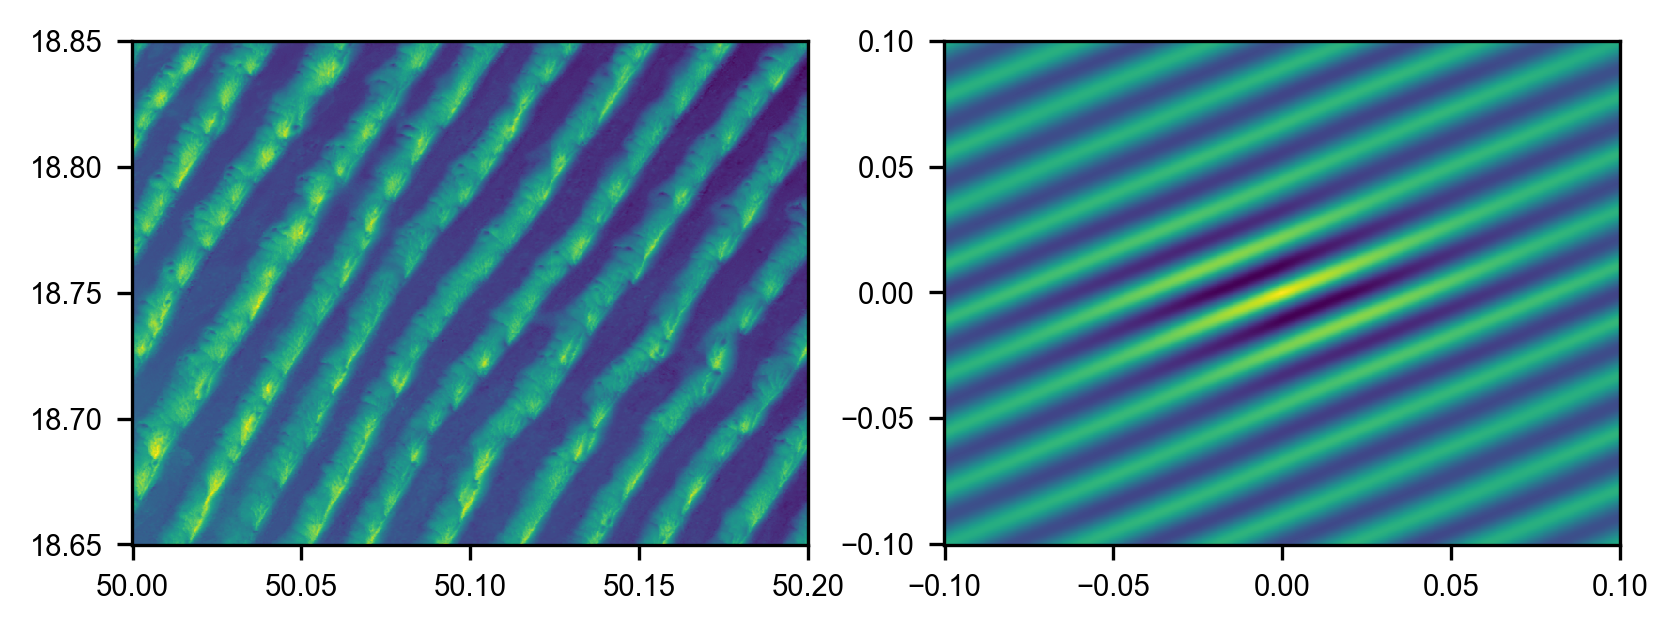

In [12]:
plt.subplot(221)
plt.pcolor(lon,lat,z)
plt.subplot(222)
plt.pcolor(lon_r,lat_r,z_r.T)

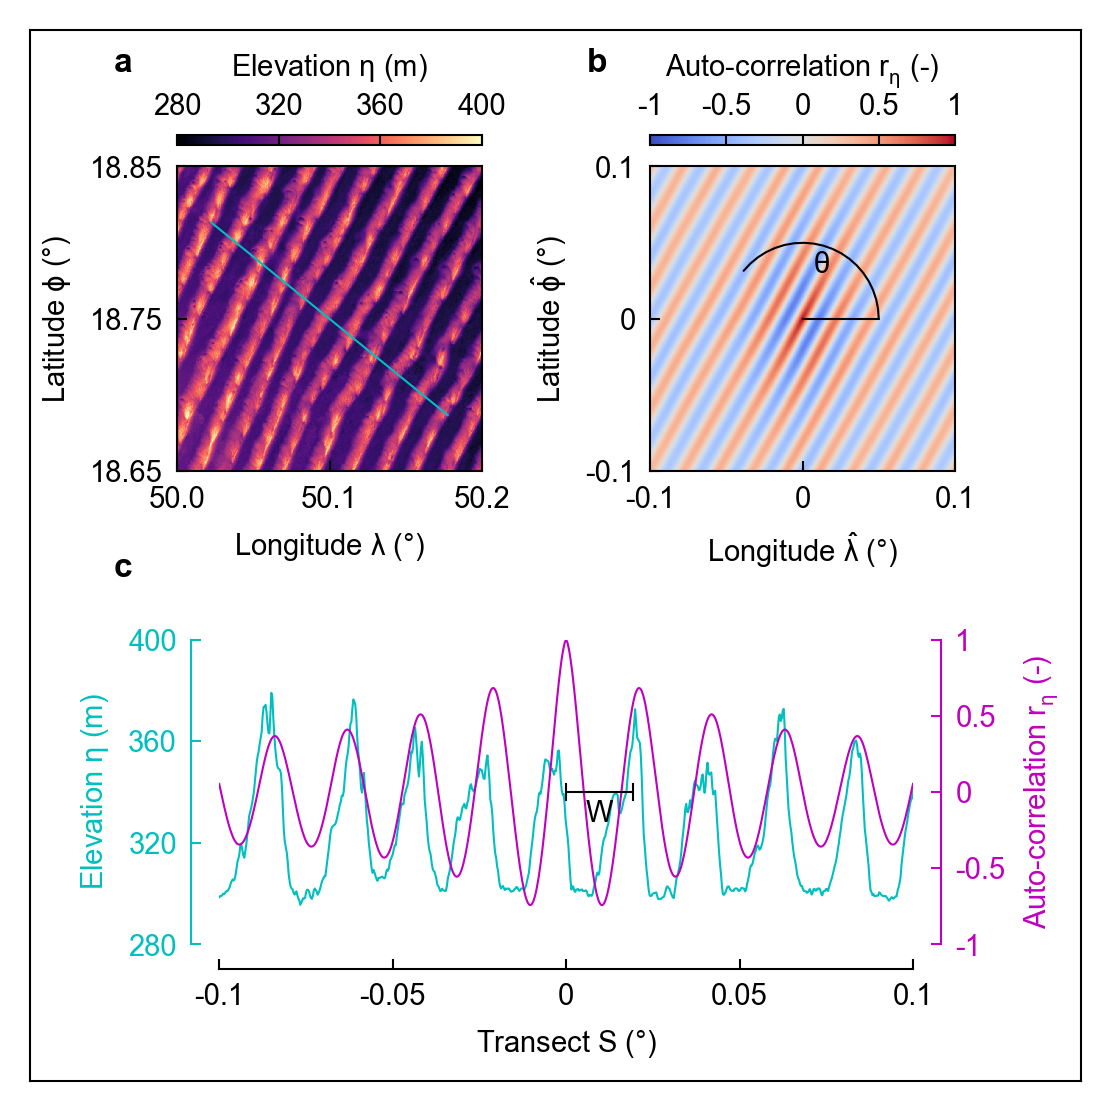

In [16]:
draft = True

lw = 0.5 #pt

hbuf = 0.02
wbuf = 0.16
cbh  = 0.01
pltspan = 0.29
blowbuf = 0.04
labbuf  = 0.06

ax0l,ax0b,ax0w,ax0h = 0.14,0.58,pltspan,pltspan
cb0l,cb0b,cb0w,cb0h = ax0l,ax0b+ax0h+hbuf,ax0w,cbh
ax1l,ax1b,ax1w,ax1h = ax0l+ax0w+wbuf,ax0b,ax0w,ax0h
cb1l,cb1b,cb1w,cb1h = ax1l,ax1b+ax1h+hbuf,ax1w,cbh
ax2l,ax2b,ax2w,ax2h = ax0l+blowbuf,0.13,ax0w*2+wbuf-2*blowbuf,ax0h

lonticks = [50.00,50.10,50.20]
latticks = [18.65,18.75,18.85]
etaticks = [280,320,360,400]

lonrticks = [-0.1,0,0.1]
latrticks = [-0.1,0,0.1]
corrticks = [-1,-0.5,0,0.5,1]

tticks = [-0.1,-0.05,0,0.05,0.1]

boxheight = 0.1

tcol = 'c'
rcol = 'm'


fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)

ax00.text(cb0l-labbuf,cb0b+cbh+labbuf,'a',fontsize=8, weight='bold')
ax00.text(cb1l-labbuf,cb1b+cbh+labbuf,'b',fontsize=8, weight='bold')
ax00.text(ax2l-blowbuf-labbuf,ax2b+ax2h+labbuf,'c',fontsize=8, weight='bold')

if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])

#the vmin and vmax are set by where we want the specific ticks to be within the graph
#rasterised will make pdf better and save as much vetter
pc0 = plt.pcolor(lon,lat,z,cmap='magma',vmin=etaticks[0],vmax=etaticks[-1],rasterized=True)

#plots the transect, lw we set at the top, and the colours a common within the top and bottom plot 
plt.plot(tlon,tlat,lw=lw,c=tcol)

#setting the limits for the x axis where we set for the first and last values
ax0.set_xlim(lonticks[0],lonticks[-1])
ax0.set_xticks(lonticks)

#set the ticks as the predetermined points and the predetermined labels
ax0.set_xticklabels(lonticks)

#set_xlabel because the figure itself is a varible therefore 
ax0.set_xlabel('Longitude $\\lambda$ ($\\degree$)')

ax0.set_ylim(latticks[0],latticks[-1])
ax0.set_yticks(latticks)
ax0.set_yticklabels(latticks)
ax0.set_ylabel('Latitude $\\phi$ ($\\degree$)')


ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])

pc1 = plt.pcolor(lon_r,lat_r,z_r,cmap='coolwarm',vmin=corrticks[0],vmax=corrticks[-1],rasterized=True)

#making the theta line
temptheta = np.linspace(0,angle,20)
tempr = np.max(lon_r)*0.5

#solid_capstyl='round' makes the ends of the line round instead of straight 
plt.plot([0,tempr],[0,0],lw=lw,c='k',solid_capstyle='round')
plt.plot(tempr*np.cos(temptheta),tempr*np.sin(temptheta),lw=lw,c='k',solid_capstyle='round')
plt.text(tempr*0.75*np.cos(angle/2),tempr*0.75*np.sin(angle/2),'$\\theta$',ha='center',va='center')
#ha and va are horixonal and vertical alignment

ax1.set_xlim(lonrticks[0],lonrticks[-1])
ax1.set_xticks(lonrticks)
ax1.set_xticklabels(lonrticks)
ax1.set_xlabel('Longitude $\\hat{\\lambda}$ ($\\degree$)')

ax1.set_ylim(latrticks[0],latrticks[-1])
ax1.set_yticks(latrticks)
ax1.set_yticklabels(latrticks)
ax1.set_ylabel('Latitude $\\hat{\\phi}$ ($\\degree$)')


ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])

ax2.plot(ts,tz,lw=lw,c=tcol)

ax2.set_xlim(tticks[0],tticks[-1])
ax2.set_xticks(tticks)
ax2.set_xticklabels(tticks)
ax2.set_xlabel('Transect $S$ ($\\degree$)')

ax2.set_ylim(etaticks[0],etaticks[-1])
ax2.set_yticks(etaticks)
ax2.set_yticklabels(etaticks,color=tcol)
ax2.set_ylabel('Elevation $\\eta$ (m)',color=tcol)

#makes the duplicate axis which as a common x avis with ax2 
ax3 = ax2.twinx()

ax3.plot(ts_r,tz_r,lw=lw,c=rcol)

#plots the transect in the autocorrelation function
#makes the horisontal bar
ax3.plot([0,spacing],[0,0],lw=lw,c='k')
ax3.plot([0,0],[-boxheight/2,boxheight/2],lw=lw,c='k')# makes the two vertical lines
ax3.plot([spacing,spacing],[-boxheight/2,boxheight/2],lw=lw,c='k')
ax3.text(spacing/2,-boxheight/2,'$W$',ha='center',va='top')# makes the W lable 

ax3.set_ylim(corrticks[0],corrticks[-1])
ax3.set_yticks(corrticks)
ax3.set_yticklabels(corrticks,color=rcol)
ax3.set_ylabel('Auto-correlation $r_\\eta$ (-)',color=rcol)

# the plot colour functio, choosing its orientation, link it to an axis and then the ticks
cbar0_ax = fig.add_axes([cb0l,cb0b,cb0w,cb0h])
cb0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=etaticks)

#choosing where the labels go 
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')

#choosing the label on the colorbat
cb0.ax.set_xlabel('Elevation $\\eta$ (m)')

#setting the tick labels 
cb0.ax.set_xticklabels(etaticks)


cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(pc1, orientation='horizontal',cax=cbar1_ax, ticks=corrticks)
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Auto-correlation $r_\\eta$ (-)')
cb1.ax.set_xticklabels(corrticks)


for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw) 
cb0.outline.set_linewidth(lw)
cb1.outline.set_linewidth(lw)


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(tcol)
ax2.tick_params(axis='y', colors=tcol)
ax2.spines['left'].set_position(('axes', -blowbuf))
ax2.spines['bottom'].set_position(('axes', -2*blowbuf))

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_color(rcol)
ax3.tick_params(axis='y', colors=rcol)
ax3.spines['right'].set_position(('axes', 1+blowbuf))


fig.set_size_inches(89/25.4,89/25.4,forward=True)
if draft==False:
    plt.savefig('example.pdf',dpi=300)
    plt.savefig('example.png',dpi=300)

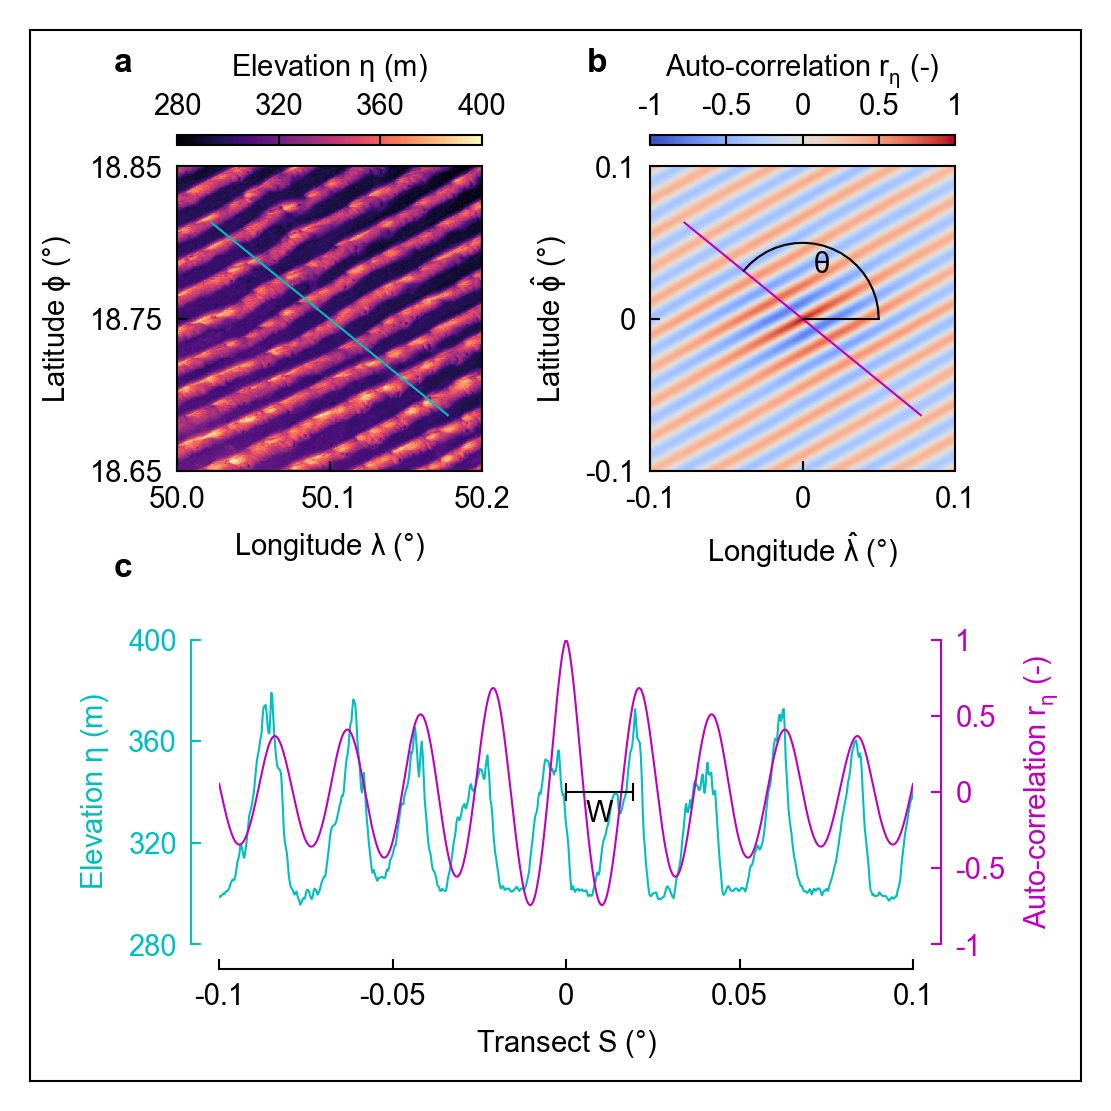

In [17]:
draft = True 

# setting variables
lw = 0.5 #pt

hbuf = 0.02 #
wbuf = 0.16
cbh  = 0.01
pltspan = 0.29 #plot is width/height of the top plots 
blowbuf = 0.04
labbuf  = 0.06

#links the left and righg axis together eg. if you move one axis to the right then the other will also move towards the right 
ax0l,ax0b,ax0w,ax0h = 0.14,0.58,pltspan,pltspan
cb0l,cb0b,cb0w,cb0h = ax0l,ax0b+ax0h+hbuf,ax0w,cbh
ax1l,ax1b,ax1w,ax1h = ax0l+ax0w+wbuf,ax0b,ax0w,ax0h
cb1l,cb1b,cb1w,cb1h = ax1l,ax1b+ax1h+hbuf,ax1w,cbh
ax2l,ax2b,ax2w,ax2h = ax0l+blowbuf,0.13,ax0w*2+wbuf-2*blowbuf,ax0h

lonticks = [50.00,50.10,50.20]
latticks = [18.65,18.75,18.85]
etaticks = [280,320,360,400]

lonrticks = [-0.1,0,0.1]
latrticks = [-0.1,0,0.1]
corrticks = [-1,-0.5,0,0.5,1]

tticks = [-0.1,-0.05,0,0.05,0.1]

boxheight = 0.1

tcol = 'c'
rcol = 'm'


fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)

ax00.text(cb0l-labbuf,cb0b+cbh+labbuf,'a',fontsize=8, weight='bold')
ax00.text(cb1l-labbuf,cb1b+cbh+labbuf,'b',fontsize=8, weight='bold')
ax00.text(ax2l-blowbuf-labbuf,ax2b+ax2h+labbuf,'c',fontsize=8, weight='bold')

# if the draft function at top, it will make the axis and get rid of the ticks and turn the outside lines
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])

pc0 = plt.pcolor(lon,lat,z.T,cmap='magma',vmin=etaticks[0],vmax=etaticks[-1],rasterized=True)
plt.plot(tlon,tlat,lw=lw,c=tcol)

ax0.set_xlim(lonticks[0],lonticks[-1])
ax0.set_xticks(lonticks)
ax0.set_xticklabels(lonticks)
ax0.set_xlabel('Longitude $\\lambda$ ($\\degree$)')

ax0.set_ylim(latticks[0],latticks[-1])
ax0.set_yticks(latticks)
ax0.set_yticklabels(latticks)
ax0.set_ylabel('Latitude $\\phi$ ($\\degree$)')


ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])

pc1 = plt.pcolor(lon_r,lat_r,z_r.T,cmap='coolwarm',vmin=corrticks[0],vmax=corrticks[-1],rasterized=True)
plt.plot(tlon_r,tlat_r,c=rcol,lw=lw)

temptheta = np.linspace(0,angle,20)
tempr = np.max(lon_r)*0.5
plt.plot([0,tempr],[0,0],lw=lw,c='k',solid_capstyle='round')
plt.plot(tempr*np.cos(temptheta),tempr*np.sin(temptheta),lw=lw,c='k',solid_capstyle='round')
plt.text(tempr*0.75*np.cos(angle/2),tempr*0.75*np.sin(angle/2),'$\\theta$',ha='center',va='center')

ax1.set_xlim(lonrticks[0],lonrticks[-1])
ax1.set_xticks(lonrticks)
ax1.set_xticklabels(lonrticks)
ax1.set_xlabel('Longitude $\\hat{\\lambda}$ ($\\degree$)')

ax1.set_ylim(latrticks[0],latrticks[-1])
ax1.set_yticks(latrticks)
ax1.set_yticklabels(latrticks)
ax1.set_ylabel('Latitude $\\hat{\\phi}$ ($\\degree$)')


ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])

ax2.plot(ts,tz,lw=lw,c=tcol)

ax2.set_xlim(tticks[0],tticks[-1])
ax2.set_xticks(tticks)
ax2.set_xticklabels(tticks)
ax2.set_xlabel('Transect $S$ ($\\degree$)')

ax2.set_ylim(etaticks[0],etaticks[-1])
ax2.set_yticks(etaticks)
ax2.set_yticklabels(etaticks,color=tcol)
ax2.set_ylabel('Elevation $\\eta$ (m)',color=tcol)

ax3 = ax2.twinx()

ax3.plot(ts_r,tz_r,lw=lw,c=rcol)

ax3.plot([0,spacing],[0,0],lw=lw,c='k')
ax3.plot([0,0],[-boxheight/2,boxheight/2],lw=lw,c='k')
ax3.plot([spacing,spacing],[-boxheight/2,boxheight/2],lw=lw,c='k')
ax3.text(spacing/2,-boxheight/2,'$W$',ha='center',va='top')

ax3.set_ylim(corrticks[0],corrticks[-1])
ax3.set_yticks(corrticks)
ax3.set_yticklabels(corrticks,color=rcol)
ax3.set_ylabel('Auto-correlation $r_\\eta$ (-)',color=rcol)


cbar0_ax = fig.add_axes([cb0l,cb0b,cb0w,cb0h])
cb0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=etaticks)
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('Elevation $\\eta$ (m)')
cb0.ax.set_xticklabels(etaticks)
cb0.ax.tick_params(width=lw,length=lw*3,which='both',direction='in')


cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(pc1, orientation='horizontal',cax=cbar1_ax, ticks=corrticks)
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Auto-correlation $r_\\eta$ (-)')
cb1.ax.set_xticklabels(corrticks)
cb1.ax.tick_params(width=lw,length=lw*3,which='both',direction='in')


for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)       
cb0.outline.set_linewidth(lw)
cb1.outline.set_linewidth(lw)


# for the bottom plot getting rid of the 
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(tcol)# setting the left one to be cyan 
ax2.tick_params(axis='y', colors=tcol)
ax2.spines['left'].set_position(('axes', -blowbuf)) # moving the left axis spine to be near
ax2.spines['bottom'].set_position(('axes', -2*blowbuf))

# ax3 is a dumplicate of ax2, therefore we need to get rid of hte top acxis 
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_color(rcol)
ax3.tick_params(axis='y', colors=rcol)
ax3.spines['right'].set_position(('axes', 1+blowbuf))

#sets the overall size of the figure to fit the thing
fig.set_size_inches(89/25.4,89/25.4,forward=True)

# not saving the figure if the draft is false, true will save, will be able to save things onto computer by putting in file directory 
if draft==False:
    plt.savefig('example.pdf',dpi=300)
    plt.savefig('example.png',dpi=300)

# Nice Graph Notes

- 